<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/bro.png" width="100px"></div>

# Bro to Spark: Clustering
In this notebook we will pull Bro data into Spark then do some analysis and clustering. The first step is to convert your Bro log data into a Parquet file, for instructions on how to do this (just a few lines of Python code using the BAT package) please see this notebook:

<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/parquet.png" width="300px"></div>

### Bro logs to Parquet Notebook
- [Bro to Parquet to Spark](https://github.com/Kitware/bat/blob/master/notebooks/Bro_to_Parquet_to_Spark.ipynb)

Apache Parquet is a columnar storage format focused on performance. Parquet data is often used within the Hadoop ecosystem and we will specifically be using it for loading data into Spark.

<div style="float: right; margin: 0px 0px 0px 0px"><img src="images/mllib.png" width="200px"></div>
<div style="float: right; margin: 30px 0px 0px 0px"><img src="images/spark.png" width="200px"></div>

### Software
- Bro Analysis Tools (BAT): https://github.com/Kitware/bat
- Parquet: https://parquet.apache.org
- Spark: https://spark.apache.org
- Spark MLLib: https://spark.apache.org/mllib/

### Data
- Sec Repo: http://www.secrepo.com (no headers on these)
- Kitware: [data.kitware.com](https://data.kitware.com/#collection/58d564478d777f0aef5d893a) (with headers)

In [102]:
# Third Party Imports
import pyspark
from pyspark.sql import SparkSession
import pyarrow

# Local imports
import bat
from bat.log_to_parquet import log_to_parquet

# Good to print out versions of stuff
print('BAT: {:s}'.format(bat.__version__))
print('PySpark: {:s}'.format(pyspark.__version__))
print('PyArrow: {:s}'.format(pyarrow.__version__))

BAT: 0.2.9
PySpark: 2.2.0
PyArrow: 0.6.0


<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/spark.png" width="200px"></div>

# Spark It!
### Spin up Spark with 4 Parallel Executors
Here we're spinning up a local spark server with 4 parallel executors, although this might seem a bit silly since we're probably running this on a laptop, there are a couple of important observations:

<div style="float: right; margin: 20px 20px 20px 20px"><img src="images/spark_jobs.png" width="400px"></div>

- If you have 4/8 cores use them!
- It's the exact same code logic as if we were running on a distributed cluster.
- We run the same code on **DataBricks** (www.databricks.com) which is awesome BTW.



In [103]:
# Spin up a local Spark Session (with 4 executors)
spark = SparkSession.builder.master("local[4]").appName('my_awesome').getOrCreate()

<div style="float: right; margin: 50px 20px 20px -20px"><img src="images/parquet.png" width="350px"></div>
##  Read in our Parquet File
Here we're loading in a Bro HTTP log with ~2 million rows to demonstrate the functionality and do some analysis and clustering on the data. For more information on converting Bro logs to Parquet files please see our Bro to Parquet notebook:

#### Bro logs to Parquet Notebook
- [Bro to Parquet to Spark](https://github.com/Kitware/bat/blob/master/notebooks/Bro_to_Parquet_to_Spark.ipynb)

In [104]:
# Have Spark read in the Parquet File
spark_df = spark.read.parquet("dns.parquet")

<div style="float: left; margin: 20px 20px 20px 20px"><img src="images/eyeball.jpeg" width="150px"></div>
# Lets look at our data
We should always inspect out data when it comes in. Look at both the data values and the data types to make sure you're getting exactly what you should be.

In [105]:
# Get information about the Spark DataFrame
num_rows = spark_df.count()
print("Number of Rows: {:d}".format(num_rows))
columns = spark_df.columns
print("Columns: {:s}".format(','.join(columns)))

Number of Rows: 427935
Columns: AA,RA,RD,TC,TTLs,Z,answers,id.orig_h,id.orig_p,id.resp_h,id.resp_p,proto,qclass,qclass_name,qtype,qtype_name,query,rcode,rcode_name,rejected,trans_id,uid,ts


In [106]:
spark_df.groupby('qtype_name','proto').count().sort('count', ascending=False).show()

+----------+-----+------+
|qtype_name|proto| count|
+----------+-----+------+
|         A|  udp|212473|
|        NB|  udp| 77199|
|      AAAA|  udp| 54519|
|       PTR|  udp| 52991|
|       TXT|  udp| 12644|
|       SRV|  udp| 12268|
|         -|  udp|  3472|
|         *|  udp|   882|
|      AXFR|  tcp|   440|
|       SOA|  udp|   346|
|       TXT|  tcp|   226|
|         -|  tcp|   176|
|        MX|  udp|   169|
|        NS|  udp|    43|
|     HINFO|  udp|    30|
|     NAPTR|  udp|    27|
|       PTR|  tcp|    26|
|         A|  tcp|     4|
+----------+-----+------+



<div style="float: right; margin: 50px 0px 0px 20px"><img src="images/deep_dive.jpeg" width="350px"></div>

# Data looks good, lets take a deeper dive
Spark has a powerful SQL engine as well as a Machine Learning library. So now that we've loaded our Bro data we're going to utilize the Spark SQL commands to do some investigation of our data including clustering from the MLLib.

<div style="float: left; margin: 20px 0px 0px 0px"><img src="images/spark_sql.jpg" width="180px"></div>
<div style="float: left; margin: 0px 50px 0px 0px"><img src="images/mllib.png" width="180px"></div>

In [107]:
# Add a column with the string length of the DNS query
from pyspark.sql.functions import col, length

# Create new dataframe that includes two new column
spark_df = spark_df.withColumn('query_length', length(col('query')))
spark_df = spark_df.withColumn('answer_length', length(col('answers')))

In [108]:
# Plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
from bat.utils import plot_utils
plot_utils.plot_defaults()

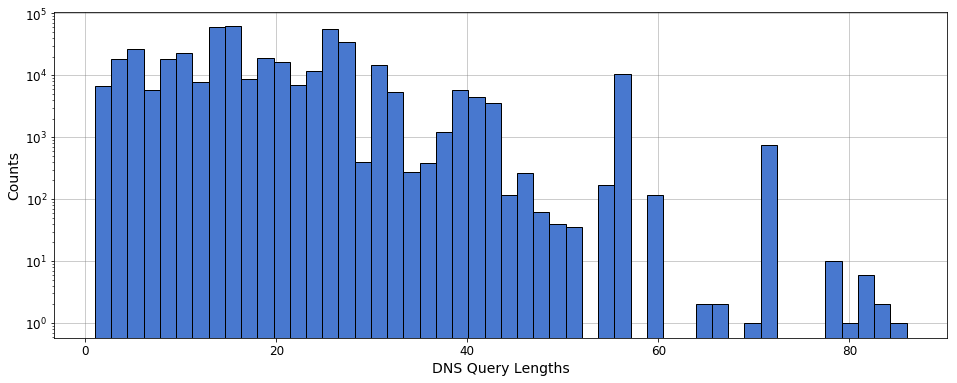

In [109]:
# Show histogram of the Spark DF request body lengths
bins, counts = spark_df.select('query_length').rdd.flatMap(lambda x: x).histogram(50)

# This is a bit awkward but I believe this is the correct way to do it
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.grid(True)
plt.xlabel('DNS Query Lengths')
plt.ylabel('Counts')

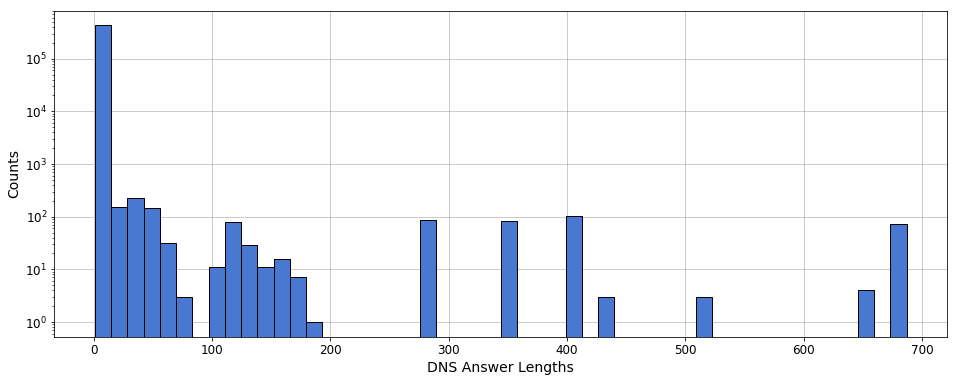

In [110]:
# Show histogram of the Spark DF request body lengths
bins, counts = spark_df.select('answer_length').rdd.flatMap(lambda x: x).histogram(50)

# This is a bit awkward but I believe this is the correct way to do it
plt.hist(bins[:-1], bins=bins, weights=counts, log=True)
plt.grid(True)
plt.xlabel('DNS Answer Lengths')
plt.ylabel('Counts')

In [111]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ['qtype_name', 'proto']
stages = [] 

for categoricalCol in categoricalColumns:
    stringIndexer = StringIndexer(inputCol=categoricalCol, 
        outputCol=categoricalCol+"Index")
    encoder = OneHotEncoder(inputCol=categoricalCol+"Index", 
        outputCol=categoricalCol+"classVec")
    stages += [stringIndexer, encoder]

numericCols = ['query_length', 'answer_length', 'Z', 'rejected']
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

pipeline = Pipeline(stages=stages)
pipelineModel = pipeline.fit(spark_df)
spark_df = pipelineModel.transform(spark_df)

In [112]:
spark_df.select('features').show()

+--------------------+
|            features|
+--------------------+
|(18,[5,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[5,13,14,15],...|
|(18,[5,13,14,15],...|
|(18,[5,13,14,15],...|
|(18,[3,13,14,15],...|
|(18,[3,13,14,15],...|
|(18,[5,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[1,13,14,15,1...|
|(18,[2,13,14,15],...|
+--------------------+
only showing top 20 rows



In [113]:
from pyspark.ml.clustering import KMeans

# Trains a k-means model.
kmeans = KMeans().setK(70)
model = kmeans.fit(spark_df)

In [114]:
# Evaluate clustering by computing Within Set Sum of Squared Errors.
wssse = model.computeCost(spark_df)
print("Within Set Sum of Squared Errors = " + str(wssse))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Within Set Sum of Squared Errors = 120733.85472213484
Cluster Centers: 
[  9.50906344e-01   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.74751834e-02   0.00000000e+00   0.00000000e+00   9.71083297e-04
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   6.47388865e-04   9.97410445e-01   1.14872680e+01   1.00000000e+00
   0.00000000e+00   9.17134225e-03]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   1.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   1.00000000e+00   2.72002232e+01   1.00360999e+00
   0.00000000e+00   1.60808638e-03]
[   0.    0.    0.    0.    0.    0.    0.    0.    1.    0.    0.    0.
    0.    0.   10.  687.    0.    0.]
[  0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   9.63855422e-02   0.00000000e+00
   9.03614458e-01   0.00000000e+00   0.00000000e+00   0

In [115]:
features = ['qtype_name', 'proto', 'query_length', 'answer_length', 'Z', 'rejected']
transformed = model.transform(spark_df).select(features + ['prediction'])
transformed.collect()
transformed.show()

+----------+-----+------------+-------------+---+--------+----------+
|qtype_name|proto|query_length|answer_length|  Z|rejected|prediction|
+----------+-----+------------+-------------+---+--------+----------+
|       SRV|  udp|          57|            1|  1|   false|         5|
|        NB|  udp|           8|            1|  1|   false|        17|
|        NB|  udp|           8|            1|  1|   false|        17|
|        NB|  udp|           8|            1|  1|   false|        17|
|        NB|  udp|           4|            1|  1|   false|        11|
|        NB|  udp|           4|            1|  1|   false|        11|
|        NB|  udp|           4|            1|  1|   false|        11|
|        NB|  udp|           6|            1|  1|   false|        38|
|        NB|  udp|           6|            1|  1|   false|        38|
|        NB|  udp|           6|            1|  1|   false|        38|
|       SRV|  udp|          57|            1|  0|   false|         5|
|       SRV|  udp|  

In [116]:
transformed.groupby(features + ['prediction']).count().sort('prediction').show(50)

+----------+-----+------------+-------------+---+--------+----------+-----+
|qtype_name|proto|query_length|answer_length|  Z|rejected|prediction|count|
+----------+-----+------------+-------------+---+--------+----------+-----+
|         A|  udp|          12|            1|  0|    true|         0|   26|
|         A|  udp|          11|            1|  0|   false|         0| 4713|
|       TXT|  tcp|          12|            1|  0|   false|         0|   19|
|       TXT|  udp|          12|            1|  0|    true|         0|   15|
|     HINFO|  udp|          12|            1|  0|   false|         0|    6|
|       TXT|  udp|          12|            1|  0|   false|         0|  401|
|         *|  udp|          12|            1|  0|   false|         0|    9|
|       TXT|  tcp|          12|            1|  0|    true|         0|    5|
|         A|  udp|          11|            1|  0|    true|         0|   39|
|         A|  udp|          12|            1|  0|   false|         0| 4035|
|       PTR|

# More Coming...

<div style="float: right; margin: 50px 0px 0px -20px"><img src="https://www.kitware.com/img/small_logo_over.png" width="250px"></div>
## Wrap Up
Well that's it for this notebook, we pulled in Bro data from a Parquet file, then did some digging with high speed, parallel SQL operations and we clustered our data to organize the restuls.

If you liked this notebook please visit the [BAT](https://github.com/Kitware/bat) project for more notebooks and examples.